In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/데이터스쿨 공부코드/project/Final_project

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/데이터스쿨 공부코드/project/Final_project


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import platform as pf
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

plt.rcParams['axes.unicode_minus']=False
# 마이너스 기호 문제 해결하기
# mpl.rcParams['axes.unicode_minus'] = False

In [3]:
sales_df = pd.read_csv('./Onlinesales_info.csv')
customer_df = pd.read_csv('./Customer_info.csv')
discount_df = pd.read_csv('./Discount_info.csv')
marketing_df = pd.read_csv('./Marketing_info.csv')
tax_df = pd.read_csv('./Tax_info.csv')
len(sales_df), len(customer_df), len(discount_df), len(marketing_df), len(tax_df)

(52924, 1468, 204, 365, 20)

### Target_df 생성

- sales_df와 customer_df merge

In [4]:
tmp_df = pd.merge(sales_df, customer_df, how='inner', on='고객ID')
tmp_df.tail(2)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간
52922,USER_0562,Transaction_25059,2019-12-31,Product_0985,Nest-USA,5,80.52,6.50,Clicked,여,California,7
52923,USER_0562,Transaction_25060,2019-12-31,Product_0984,Nest-USA,4,80.52,19.99,Clicked,여,California,7


In [5]:
month_dict = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

for i in month_dict.keys():
  discount_df.loc[discount_df['월'] == i, '월'] = month_dict[i]

discount_df.head(2)

,월,제품카테고리,쿠폰코드,할인율
0,01,Apparel,SALE10,10
1,02,Apparel,SALE20,20


- discount_df와 merge
- tax_df와 merge

In [6]:
tmp_df['월'] = [i.split('-')[1] for i in tmp_df['거래날짜']]
tmp_df = pd.merge(tmp_df, discount_df, how='left', on=['월', '제품카테고리'], )
tmp_df = pd.merge(tmp_df, tax_df, how='left', on=['제품카테고리']).drop('월', axis=1)

- 구매원가 컬럼 추가
  - 제품별 수량 * 평균 금액 * Tax
  - 할인율이 적용되기 전 구매 금액(택스 포함)

In [7]:
tmp_product_cost = []
for i, r in tmp_df.iterrows():
  tmp_result = round(r['수량'] * r['평균금액'] * (1 + r['GST']), 2)
  tmp_product_cost.append(tmp_result)

tmp_df['구매원가'] = tmp_product_cost

- 할인가 컬럼 추가
  - 제품별 할인이 적용된 금액 = 구매원가 * (1 - (할인율/100))
  - 쿠폰 상태가 Used인 제품에 쿠폰의 할인율을 적용한 금액(택스 포함됨)
  - 할인 쿠폰이 없는 카테고리의 경우, 할인가 = 구매원가
  - 배송비는 추가되어 있지 않음(거래ID 당 1회만 추가되는 것이기 때문)

In [9]:
tmp_not_issued = set(tmp_df['제품카테고리'].unique()) - set(discount_df['제품카테고리'].unique())

tmp_product_dc_cost = []
for i, r in tmp_df.iterrows():
  if r['쿠폰상태'] == 'Used':
    if r['제품카테고리'] in tmp_not_issued:
      tmp_result = r['구매원가']
    else:
      tmp_result = round(r['구매원가'] * (1.- (r['할인율']/100)), 2)
  else:
    tmp_result = r['구매원가']
  tmp_product_dc_cost.append(tmp_result)

tmp_df['할인가'] = tmp_product_dc_cost

In [12]:
tmp_df[tmp_df['제품카테고리'] == 'Fun'].head(1)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,쿠폰코드,할인율,GST,구매원가,할인가
24,USER_1358,Transaction_0020,2019-01-01,Product_1138,Fun,4,9.27,6.5,Used,남,Chicago,12,NaN,NaN,0.18,43.75,43.75


- 가입날짜 컬럼 추가
  - 현재 2019.12.31일 기준 역산
  - 가입기간은 개월수로 가정
  - 1년 52주로 계산

In [14]:
import datetime
# 1년 52주
# 가입기간은 개월수로 가정

tmp_start_date = []

for i, r in tmp_df.iterrows():
  tmp_start_date.append(datetime.date(2019, 12, 31) - datetime.timedelta(weeks= (52 * r['가입기간']//12) + r['가입기간']%12))

tmp_df['가입날짜'] = tmp_start_date


In [15]:
target_df = tmp_df[['고객ID', '성별', '고객지역', '가입날짜', '가입기간', '거래ID', '거래날짜', '제품ID', '제품카테고리', '수량', '평균금액', '배송료', '쿠폰상태',
        '쿠폰코드', '할인율', 'GST', '구매원가', '할인가']]
target_df

,고객ID,성별,고객지역,가입날짜,가입기간,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,쿠폰코드,할인율,GST,구매원가,할인가
0,USER_1358,남,Chicago,2019-01-01,12,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,ELEC10,10.0,0.10,169.08,152.17
1,USER_1358,남,Chicago,2019-01-01,12,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,ELEC10,10.0,0.10,169.08,152.17
2,USER_1358,남,Chicago,2019-01-01,12,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,OFF10,10.0,0.10,2.25,2.02
3,USER_1358,남,Chicago,2019-01-01,12,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.50,Not Used,SALE10,10.0,0.18,103.43,103.43
4,USER_1358,남,Chicago,2019-01-01,12,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.50,Used,AIO10,10.0,0.18,19.47,17.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0504,여,New York,2016-02-02,45,Transaction_25056,2019-12-31,Product_0976,Nest-USA,1,121.30,6.50,Clicked,ELEC30,30.0,0.10,133.43,133.43
52920,USER_0504,여,New York,2016-02-02,45,Transaction_25057,2019-12-31,Product_0413,Apparel,1,48.92,6.50,Used,SALE30,30.0,0.18,57.73,40.41
52921,USER_0504,여,New York,2016-02-02,45,Transaction_25058,2019-12-31,Product_0989,Nest-USA,1,151.88,6.50,Used,ELEC30,30.0,0.10,167.07,116.95
52922,USER_0562,여,California,2019-04-16,7,Transaction_25059,2019-12-31,Product_0985,Nest-USA,5,80.52,6.50,Clicked,ELEC30,30.0,0.10,442.86,442.86


In [16]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52924 entries, 0 to 52923
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   고객ID    52924 non-null  object 
 1   성별      52924 non-null  object 
 2   고객지역    52924 non-null  object 
 3   가입날짜    52924 non-null  object 
 4   가입기간    52924 non-null  int64  
 5   거래ID    52924 non-null  object 
 6   거래날짜    52924 non-null  object 
 7   제품ID    52924 non-null  object 
 8   제품카테고리  52924 non-null  object 
 9   수량      52924 non-null  int64  
 10  평균금액    52924 non-null  float64
 11  배송료     52924 non-null  float64
 12  쿠폰상태    52924 non-null  object 
 13  쿠폰코드    52524 non-null  object 
 14  할인율     52524 non-null  float64
 15  GST     52924 non-null  float64
 16  구매원가    52924 non-null  float64
 17  할인가     52924 non-null  float64
dtypes: float64(6), int64(2), object(10)
memory usage: 9.7+ MB


- 쿠폰코드, 할인율 Nan 값 400개 rows

In [18]:
set(target_df['제품카테고리'].unique()) - set(discount_df['제품카테고리'].unique())

{'Backpacks', 'Fun', 'Google', 'More Bags'}

---

### 개별 거래 테이블 = 장바구니 테이블



In [19]:
# 고객 장바구니 단가 알아보기
shoppingcart_df = target_df[['고객ID', '거래ID', '수량', '구매원가', '할인가']].groupby(by=['고객ID', '거래ID']).sum().reset_index()
shoppingcart_df

,고객ID,거래ID,수량,구매원가,할인가
0,USER_0000,Transaction_16900,3,35.69,24.98
1,USER_0001,Transaction_20178,2,13.00,12.47
2,USER_0001,Transaction_20179,4,21.66,21.66
3,USER_0001,Transaction_20180,1,163.90,163.90
4,USER_0001,Transaction_20181,1,163.90,163.90
...,...,...,...,...,...
26626,USER_1467,Transaction_18634,1,103.95,103.95
26627,USER_1467,Transaction_18635,12,40.43,39.11
26628,USER_1467,Transaction_18636,2,28.29,25.46
26629,USER_1467,Transaction_18637,3,57.80,52.02


In [20]:
tmp_df = target_df.groupby(['고객ID', '거래ID'])['제품카테고리'].apply(list).reset_index()
tmp_df['제품카테고리수'] = tmp_df['제품카테고리'].apply(lambda x: len(x))
tmp_df

,고객ID,거래ID,제품카테고리,제품카테고리수
0,USER_0000,Transaction_16900,"[Apparel, Office]",2
1,USER_0001,Transaction_20178,"[Office, Apparel]",2
2,USER_0001,Transaction_20179,"[Lifestyle, Apparel]",2
3,USER_0001,Transaction_20180,[Nest-USA],1
4,USER_0001,Transaction_20181,[Nest-USA],1
...,...,...,...,...
26626,USER_1467,Transaction_18634,[Nest],1
26627,USER_1467,Transaction_18635,"[Drinkware, Office, Office]",3
26628,USER_1467,Transaction_18636,"[Apparel, Apparel]",2
26629,USER_1467,Transaction_18637,"[Apparel, Apparel]",2


In [21]:
shoppingcart_df = pd.merge(shoppingcart_df, tmp_df, how='left', on=['고객ID', '거래ID']).sort_values(['고객ID', '거래ID']).reset_index(drop=True)
shoppingcart_df

,고객ID,거래ID,수량,구매원가,할인가,제품카테고리,제품카테고리수
0,USER_0000,Transaction_16900,3,35.69,24.98,"[Apparel, Office]",2
1,USER_0001,Transaction_20178,2,13.00,12.47,"[Office, Apparel]",2
2,USER_0001,Transaction_20179,4,21.66,21.66,"[Lifestyle, Apparel]",2
3,USER_0001,Transaction_20180,1,163.90,163.90,[Nest-USA],1
4,USER_0001,Transaction_20181,1,163.90,163.90,[Nest-USA],1
...,...,...,...,...,...,...,...
26626,USER_1467,Transaction_18634,1,103.95,103.95,[Nest],1
26627,USER_1467,Transaction_18635,12,40.43,39.11,"[Drinkware, Office, Office]",3
26628,USER_1467,Transaction_18636,2,28.29,25.46,"[Apparel, Apparel]",2
26629,USER_1467,Transaction_18637,3,57.80,52.02,"[Apparel, Apparel]",2


In [22]:
# 배송비 추가
# 거래ID 당 배송비는 동일

shoppingcart_df['배송료'] = target_df.drop_duplicates(subset=['고객ID', '거래ID'], keep='first').sort_values(['고객ID', '거래ID']).reset_index(drop=True)['배송료']
shoppingcart_df['총결제금액'] = shoppingcart_df['할인가'] + shoppingcart_df['배송료']
shoppingcart_df

,고객ID,거래ID,수량,구매원가,할인가,제품카테고리,제품카테고리수,배송료,총결제금액
0,USER_0000,Transaction_16900,3,35.69,24.98,"[Apparel, Office]",2,75.00,99.98
1,USER_0001,Transaction_20178,2,13.00,12.47,"[Office, Apparel]",2,20.85,33.32
2,USER_0001,Transaction_20179,4,21.66,21.66,"[Lifestyle, Apparel]",2,6.00,27.66
3,USER_0001,Transaction_20180,1,163.90,163.90,[Nest-USA],1,6.00,169.90
4,USER_0001,Transaction_20181,1,163.90,163.90,[Nest-USA],1,6.00,169.90
...,...,...,...,...,...,...,...,...,...
26626,USER_1467,Transaction_18634,1,103.95,103.95,[Nest],1,6.00,109.95
26627,USER_1467,Transaction_18635,12,40.43,39.11,"[Drinkware, Office, Office]",3,6.00,45.11
26628,USER_1467,Transaction_18636,2,28.29,25.46,"[Apparel, Apparel]",2,6.50,31.96
26629,USER_1467,Transaction_18637,3,57.80,52.02,"[Apparel, Apparel]",2,6.00,58.02


In [23]:
#거래날짜, 가입날짜 추가
shoppingcart_df['거래날짜'] = [i[0] for i in target_df.groupby(['고객ID', '거래ID'])['거래날짜'].apply(list)]
shoppingcart_df['가입날짜'] = [i[0] for i in target_df.groupby(['고객ID', '거래ID'])['가입날짜'].apply(list)]
shoppingcart_df

,고객ID,거래ID,수량,구매원가,할인가,제품카테고리,제품카테고리수,배송료,총결제금액,거래날짜,가입날짜
0,USER_0000,Transaction_16900,3,35.69,24.98,"[Apparel, Office]",2,75.00,99.98,2019-09-15,2017-04-18
1,USER_0001,Transaction_20178,2,13.00,12.47,"[Office, Apparel]",2,20.85,33.32,2019-11-01,2018-03-13
2,USER_0001,Transaction_20179,4,21.66,21.66,"[Lifestyle, Apparel]",2,6.00,27.66,2019-11-01,2018-03-13
3,USER_0001,Transaction_20180,1,163.90,163.90,[Nest-USA],1,6.00,169.90,2019-11-02,2018-03-13
4,USER_0001,Transaction_20181,1,163.90,163.90,[Nest-USA],1,6.00,169.90,2019-11-02,2018-03-13
...,...,...,...,...,...,...,...,...,...,...,...
26626,USER_1467,Transaction_18634,1,103.95,103.95,[Nest],1,6.00,109.95,2019-10-10,2017-01-03
26627,USER_1467,Transaction_18635,12,40.43,39.11,"[Drinkware, Office, Office]",3,6.00,45.11,2019-10-10,2017-01-03
26628,USER_1467,Transaction_18636,2,28.29,25.46,"[Apparel, Apparel]",2,6.50,31.96,2019-10-10,2017-01-03
26629,USER_1467,Transaction_18637,3,57.80,52.02,"[Apparel, Apparel]",2,6.00,58.02,2019-10-10,2017-01-03


In [24]:
#쿠폰사용여부 추가
# 1: 사용(Used), 0: 미사용(Not used)

shoppingcart_df['쿠폰사용여부'] = [1 if 'Used' in i else 0 for i in target_df.groupby(['고객ID', '거래ID'])['쿠폰상태'].apply(list)]
shoppingcart_df

,고객ID,거래ID,수량,구매원가,할인가,제품카테고리,제품카테고리수,배송료,총결제금액,거래날짜,가입날짜,쿠폰사용여부
0,USER_0000,Transaction_16900,3,35.69,24.98,"[Apparel, Office]",2,75.00,99.98,2019-09-15,2017-04-18,1
1,USER_0001,Transaction_20178,2,13.00,12.47,"[Office, Apparel]",2,20.85,33.32,2019-11-01,2018-03-13,1
2,USER_0001,Transaction_20179,4,21.66,21.66,"[Lifestyle, Apparel]",2,6.00,27.66,2019-11-01,2018-03-13,0
3,USER_0001,Transaction_20180,1,163.90,163.90,[Nest-USA],1,6.00,169.90,2019-11-02,2018-03-13,0
4,USER_0001,Transaction_20181,1,163.90,163.90,[Nest-USA],1,6.00,169.90,2019-11-02,2018-03-13,0
...,...,...,...,...,...,...,...,...,...,...,...,...
26626,USER_1467,Transaction_18634,1,103.95,103.95,[Nest],1,6.00,109.95,2019-10-10,2017-01-03,0
26627,USER_1467,Transaction_18635,12,40.43,39.11,"[Drinkware, Office, Office]",3,6.00,45.11,2019-10-10,2017-01-03,1
26628,USER_1467,Transaction_18636,2,28.29,25.46,"[Apparel, Apparel]",2,6.50,31.96,2019-10-10,2017-01-03,1
26629,USER_1467,Transaction_18637,3,57.80,52.02,"[Apparel, Apparel]",2,6.00,58.02,2019-10-10,2017-01-03,1


In [25]:
shoppingcart_df.columns

Index(['고객ID', '거래ID', '수량', '구매원가', '할인가', '제품카테고리', '제품카테고리수', '배송료',
       '총결제금액', '거래날짜', '가입날짜', '쿠폰사용여부'],
      dtype='object')

In [26]:
shoppingcart_df = shoppingcart_df[['고객ID', '가입날짜', '거래날짜', '거래ID', '제품카테고리', '제품카테고리수', '수량', '구매원가', '할인가', '쿠폰사용여부', '배송료','총결제금액']]
shoppingcart_df.rename(columns={'수량': '구매제품수'}, inplace=True)
shoppingcart_df

,고객ID,가입날짜,거래날짜,거래ID,제품카테고리,제품카테고리수,구매제품수,구매원가,할인가,쿠폰사용여부,배송료,총결제금액
0,USER_0000,2017-04-18,2019-09-15,Transaction_16900,"[Apparel, Office]",2,3,35.69,24.98,1,75.00,99.98
1,USER_0001,2018-03-13,2019-11-01,Transaction_20178,"[Office, Apparel]",2,2,13.00,12.47,1,20.85,33.32
2,USER_0001,2018-03-13,2019-11-01,Transaction_20179,"[Lifestyle, Apparel]",2,4,21.66,21.66,0,6.00,27.66
3,USER_0001,2018-03-13,2019-11-02,Transaction_20180,[Nest-USA],1,1,163.90,163.90,0,6.00,169.90
4,USER_0001,2018-03-13,2019-11-02,Transaction_20181,[Nest-USA],1,1,163.90,163.90,0,6.00,169.90
...,...,...,...,...,...,...,...,...,...,...,...,...
26626,USER_1467,2017-01-03,2019-10-10,Transaction_18634,[Nest],1,1,103.95,103.95,0,6.00,109.95
26627,USER_1467,2017-01-03,2019-10-10,Transaction_18635,"[Drinkware, Office, Office]",3,12,40.43,39.11,1,6.00,45.11
26628,USER_1467,2017-01-03,2019-10-10,Transaction_18636,"[Apparel, Apparel]",2,2,28.29,25.46,1,6.50,31.96
26629,USER_1467,2017-01-03,2019-10-10,Transaction_18637,"[Apparel, Apparel]",2,3,57.80,52.02,1,6.00,58.02


In [86]:
# df 저장
shoppingcart_df.to_csv('shoppingcart_df.csv', sep=',', encoding='utf8', na_rep='NaN')

---

### 거래ID 기준 쿠폰 사용 비율

In [27]:
tmp_data = shoppingcart_df.groupby('쿠폰사용여부').count()['거래ID']
tmp_data

쿠폰사용여부
0    13830
1    12801
Name: 거래ID, dtype: int64

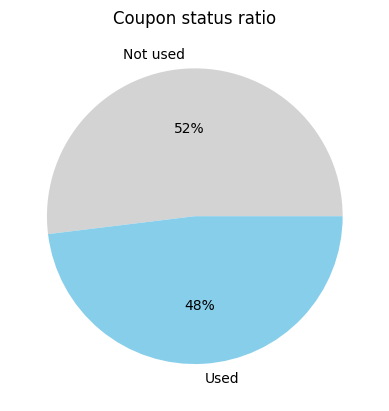

In [28]:
sum = tmp_data.sum()

plt.pie(tmp_data, labels=['Not used', 'Used'], colors=['lightgray', 'skyblue'], autopct='%.0f%%')
plt.title('Coupon status ratio');

- 약 4%의 미미한 차이로, 쿠폰이 사용되지 않은 거래가 쿠폰이 사용된 거래보다 많다.

### 평균, unique, top, freq 등 정보 확인

In [29]:
type = ['object', 'int64', 'float64']
shoppingcart_df.describe(include=type)

,고객ID,가입날짜,거래날짜,거래ID,제품카테고리,제품카테고리수,구매제품수,구매원가,할인가,쿠폰사용여부,배송료,총결제금액
count,26631,26631,26631,26631,26631,26631.000000,26631.000000,26631.000000,26631.000000,26631.000000,26631.000000,26631.000000
unique,1468,49,365,25061,2403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,USER_0118,2016-08-09,2019-11-27,Transaction_6844,[Nest-USA],NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,328,1008,213,8,9092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.987308,8.938192,194.710940,181.770739,0.480680,8.974038,190.744776
std,NaN,NaN,NaN,NaN,NaN,1.879946,43.650378,389.239758,369.150910,0.499636,14.418741,371.464456
min,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.450000,0.320000,0.000000,0.000000,4.860000
25%,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,48.360000,44.330000,0.000000,6.000000,52.430000
50%,NaN,NaN,NaN,NaN,NaN,1.000000,2.000000,130.900000,130.900000,0.000000,6.000000,136.900000
75%,NaN,NaN,NaN,NaN,NaN,2.000000,4.000000,255.695000,218.900000,1.000000,6.500000,231.825000


- 2019년 한 해 동안 발생간 거래는 총 26631건이다. (다른 유저가 동일한 거래ID를 가질 수 있어 unique 값을 보면 안 됨)
- 1년 동안 1번이라도 거래한 활성 고객 수는 1468명이다.
- 가장 구매 빈도가 높은 고객은 USER_0188이며, 빈도수는 328회이다.
- 2019년 활성 고객 중 2016년 8월 26일에 가입한 고객의 방문이 가장 많았다.(가입한 고객 수가 많은 것이 아님)
- 2019년 한 해 동안 거래가 가장 많이 발생한 날짜는 2019년 11월 27일로 총 213회이다.
- 2019년 한 해 동안 고객들이 한 번의 거래에서 평균적으로 구매한 제품 수는 9개이지만, 중앙값은 2로 편차가 크다.
- 2019년 한 해 동안 거래당 구매원가는 평균 195 달러이고, 할인구매가는 평균 181달러, 평균 할인받은 비율은 8% 정도이다.
- 배송료의 평균은 9달러이지만 3분위수는 6.5달러이다.
- 거래 건당 할인, 배송료, 세금이 모두 포함된 고객의 총결제금액의 평균은 190달러이다.

### 거래 당 구매제품수

In [30]:
tmp_df = shoppingcart_df.groupby('구매제품수').count()['거래ID'] < 100
tmp_df.value_counts()

True     270
False     15
Name: 거래ID, dtype: int64

In [31]:
shoppingcart_df.groupby('구매제품수').count()['거래ID'].sort_values(ascending=False)[:15].sum()/len(shoppingcart_df.groupby('구매제품수').count()['거래ID'])

86.1859649122807

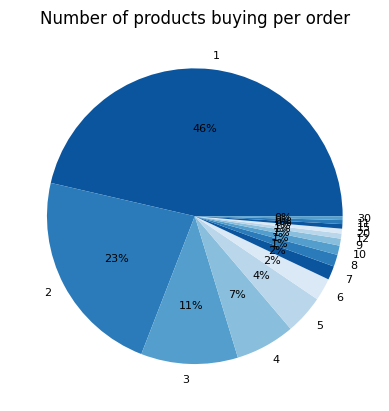

In [32]:
palette = sns.color_palette('Blues_r')
labels = shoppingcart_df.groupby('구매제품수').count()['거래ID'].sort_values(ascending=False)[:15].index
plt.pie(shoppingcart_df.groupby('구매제품수').count()['거래ID'].sort_values(ascending=False)[:15], autopct='%.0f%%', labels = labels, colors=palette, textprops={'fontsize':8})
plt.title('Number of products buying per order')
# plt.tight_layout()
plt.show()

- 거래 건당 주문제품수는 1 ~ 2150개까지 분포한다.
- 한 번의 거래에서 평균적으로 구매한 제품 수는 9개였지만, 전체에서 약 86%를 차지하는 상위 주문 제품 수 15 항목(거래건수 100 이상)으로 시각화하였다.
- 거래 1건 당 5개 이하의 제품을 주문하는 비중이 87%로, 소량주문하는 거래 건수가 많다.


### 구매제품수와 총결제금액 간 관계

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123

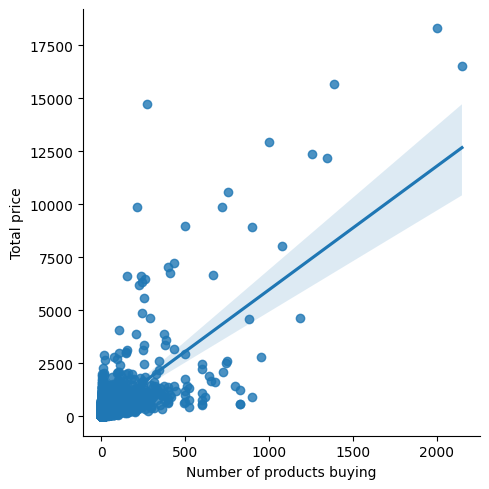

In [33]:
# 구매제품수와 총결제금액
sns.lmplot(shoppingcart_df, x='구매제품수', y='총결제금액')
plt.xlabel('Number of products buying')
plt.ylabel('Total price')
plt.show()

- 거래 1건 당 구매 수량이 많으면 총결제금액이 높아지는 경향은 보인다.
- 단, 소량 구매에도 제품 단가가 높아 총결제금액이 높은 경우와 대량 구매에도 제품 단가가 낮아 총결제금액이 낮은 경우도 많다.

---

### 고객당 구매 테이블

In [34]:
customer_buyinginfo_df = shoppingcart_df.groupby('고객ID').sum().drop('제품카테고리수', axis=1)
customer_buyinginfo_df['구매횟수'] = shoppingcart_df.groupby('고객ID')['거래ID'].count()
customer_buyinginfo_df['가입날짜'] = [i[0] for i in shoppingcart_df.groupby(['고객ID'])['가입날짜'].apply(list)]
customer_buyinginfo_df['최초거래날짜'] = [i[0] for i in shoppingcart_df.sort_values(['고객ID', '거래날짜'], ascending=[True, True]).groupby(['고객ID'])['거래날짜'].apply(list)]
customer_buyinginfo_df['최근거래날짜'] = [i[0] for i in shoppingcart_df.sort_values(['고객ID', '거래날짜'], ascending=[True, False]).groupby(['고객ID'])['거래날짜'].apply(list)]
customer_buyinginfo_df['평균결제금액'] = round(customer_buyinginfo_df['총결제금액'] / customer_buyinginfo_df['구매횟수'], 2)
customer_buyinginfo_df['평균할인차액'] = round((customer_buyinginfo_df['할인가'] - customer_buyinginfo_df['구매원가'])/customer_buyinginfo_df['구매횟수'], 2)
customer_buyinginfo_df['평균할인비율'] = round((abs(customer_buyinginfo_df['평균할인차액'])/customer_buyinginfo_df['평균결제금액']), 2)
customer_buyinginfo_df['구매제품평균금액'] = round((customer_buyinginfo_df['할인가'] / customer_buyinginfo_df['구매제품수']), 2)
customer_buyinginfo_df

,구매제품수,구매원가,할인가,쿠폰사용여부,배송료,총결제금액,구매횟수,가입날짜,최초거래날짜,최근거래날짜,평균결제금액,평균할인차액,평균할인비율,구매제품평균금액
고객ID,,,,,,,,,,,,,,
USER_0000,3,35.69,24.98,1,75.00,99.98,1,2017-04-18,2019-09-15,2019-09-15,99.98,-10.71,0.11,8.33
USER_0001,342,15902.78,15021.67,18,286.46,15308.13,31,2018-03-13,2019-03-24,2019-11-02,493.81,-28.42,0.06,43.92
USER_0002,209,1645.73,1492.42,4,81.07,1573.49,8,2016-09-13,2019-06-22,2019-10-19,196.69,-19.16,0.10,7.14
USER_0003,21,1508.36,1339.57,6,82.39,1421.96,11,2017-11-28,2019-12-14,2019-12-14,129.27,-15.34,0.12,63.79
USER_0004,56,1594.23,1369.93,7,154.49,1524.42,13,2017-04-18,2019-09-15,2019-09-15,117.26,-17.25,0.15,24.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USER_1463,46,595.58,582.38,1,94.35,676.73,3,2019-07-02,2019-04-05,2019-04-05,225.58,-4.40,0.02,12.66
USER_1464,141,2640.23,2384.13,12,222.05,2606.18,19,2016-04-19,2019-06-22,2019-10-05,137.17,-13.48,0.10,16.91
USER_1465,10,119.58,115.40,1,12.50,127.90,2,2017-11-28,2019-04-05,2019-06-20,63.95,-2.09,0.03,11.54


In [35]:
customer_buyinginfo_df = customer_buyinginfo_df[['가입날짜', '최초거래날짜', '최근거래날짜', '구매횟수', '구매제품수', '구매원가', '할인가', '배송료', '총결제금액', '평균결제금액', '평균할인차액', '평균할인비율', '구매제품평균금액']].reset_index()
customer_buyinginfo_df

,고객ID,가입날짜,최초거래날짜,최근거래날짜,구매횟수,구매제품수,구매원가,할인가,배송료,총결제금액,평균결제금액,평균할인차액,평균할인비율,구매제품평균금액
0,USER_0000,2017-04-18,2019-09-15,2019-09-15,1,3,35.69,24.98,75.00,99.98,99.98,-10.71,0.11,8.33
1,USER_0001,2018-03-13,2019-03-24,2019-11-02,31,342,15902.78,15021.67,286.46,15308.13,493.81,-28.42,0.06,43.92
2,USER_0002,2016-09-13,2019-06-22,2019-10-19,8,209,1645.73,1492.42,81.07,1573.49,196.69,-19.16,0.10,7.14
3,USER_0003,2017-11-28,2019-12-14,2019-12-14,11,21,1508.36,1339.57,82.39,1421.96,129.27,-15.34,0.12,63.79
4,USER_0004,2017-04-18,2019-09-15,2019-09-15,13,56,1594.23,1369.93,154.49,1524.42,117.26,-17.25,0.15,24.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,2019-07-02,2019-04-05,2019-04-05,3,46,595.58,582.38,94.35,676.73,225.58,-4.40,0.02,12.66
1464,USER_1464,2016-04-19,2019-06-22,2019-10-05,19,141,2640.23,2384.13,222.05,2606.18,137.17,-13.48,0.10,16.91
1465,USER_1465,2017-11-28,2019-04-05,2019-06-20,2,10,119.58,115.40,12.50,127.90,63.95,-2.09,0.03,11.54
1466,USER_1466,2015-11-24,2019-10-23,2019-10-23,1,2,327.80,327.80,6.00,333.80,333.80,0.00,0.00,163.90


- 최초거래날짜의 경우 2019년 데이터로 제한되어있음에 유의한다.
- 구매제품평균금액으로 고객의 구매 가격 상한선을 파악?

In [85]:
# df 저장
customer_buyinginfo_df.to_csv('customer_buyinginfo_df.csv', sep=',', encoding='utf8', na_rep='NaN')

---

### 평균, unique, top, freq 등 정보 확인

In [36]:
customer_buyinginfo_df.describe(include=type)

,고객ID,가입날짜,최초거래날짜,최근거래날짜,구매횟수,구매제품수,구매원가,할인가,배송료,총결제금액,평균결제금액,평균할인차액,평균할인비율,구매제품평균금액
count,1468,1468,1468,1468,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000
unique,1468,49,345,335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,USER_0000,2016-12-27,2019-01-30,2019-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,41,19,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,18.141008,162.147820,3532.252745,3297.504455,162.798093,3460.302548,180.778515,-12.117527,0.070300,37.467050
std,NaN,NaN,NaN,NaN,24.976414,312.374078,5641.434573,5300.091989,237.824772,5519.945748,123.690403,11.687509,0.058056,32.744976
min,NaN,NaN,NaN,NaN,1.000000,1.000000,1.100000,0.990000,6.000000,6.990000,6.990000,-126.940000,0.000000,0.990000
25%,NaN,NaN,NaN,NaN,5.000000,19.000000,729.952500,673.297500,38.480000,714.750000,124.952500,-16.310000,0.030000,14.047500
50%,NaN,NaN,NaN,NaN,11.000000,61.000000,1930.650000,1796.675000,93.280000,1899.320000,168.340000,-9.535000,0.060000,26.380000
75%,NaN,NaN,NaN,NaN,23.000000,178.000000,4367.287500,4078.965000,202.100000,4273.347500,210.135000,-4.915000,0.090000,49.960000


- 2019년 활성고객 중 2016년 6월 11일에 가입한 고객이 6명으로 가장 많다.
- 2019년 고객들은 평균 18회 구매했고, 가장 많이 구매한 고객은 328회 구매했다.
- 2019년 동안 가장 많은 제품을 산 고객은 총 4869개를 구매했다. 평균 구매제품수는 162개이지만, 중앙값은 61개로 편차가 크다.
- 제품을 구매하면서 배송료로 6달러 밖에 안 쓴 고객도 있지만, 3715달러를 쓴 고객도 있다.
- 2019년 연간 ARPPU(미구매고객은 없으므로 = ARPU)는 3453.9달러이다.
- 고객들은 1명당 평균 12달러의 할인을 받았고, 평균적으로 약 7%의 할인을 받은 것과 같다.
- 127달러의 할인받은 사람도 있고(30%만 사용한 체리피커가 아니라면 구매액에 비례할 것) 0달러로 할인을 못 받은 사람도 있다.
- 2019년 고객들이 구매한 제품의 평균금액은 37.4달러이다.

### 고객 당 구매횟수와 총결제금액

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:

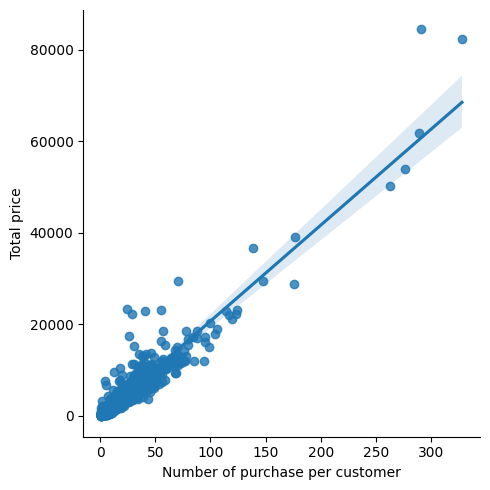

In [51]:
sns.lmplot(customer_buyinginfo_df, x='구매횟수', y='총결제금액')
plt.xlabel('Number of purchase per customer')
plt.ylabel('Total price')
plt.show()

---


In [37]:
# 2019년 말일 기준으로 최근 거래일을 일로 환산하기
today = datetime.date(2019, 12, 31)

rfm_df = customer_buyinginfo_df[['고객ID', '최근거래날짜', '구매횟수', '총결제금액']].copy()
rfm_df['최근거래날짜'] = [(today - datetime.date.fromisoformat(i)).days + 1 for i in customer_buyinginfo_df['최근거래날짜']]
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm_df


,CustomerID,Recency,Frequency,Monetary
0,USER_0000,108,1,99.98
1,USER_0001,60,31,15308.13
2,USER_0002,74,8,1573.49
3,USER_0003,18,11,1421.96
4,USER_0004,108,13,1524.42
...,...,...,...,...
1463,USER_1463,271,3,676.73
1464,USER_1464,88,19,2606.18
1465,USER_1465,195,2,127.90
1466,USER_1466,70,1,333.80


In [38]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,1468.000000,1468.000000,1468.000000
mean,145.292234,18.141008,3460.302548
std,101.936959,24.976414,5519.945748
min,1.000000,1.000000,6.990000
25%,56.000000,5.000000,714.750000
50%,132.000000,11.000000,1899.320000
75%,221.000000,23.000000,4273.347500
max,365.000000,328.000000,84405.830000


- 2019년 12월 31일 기준, 고객 한 명 당 평균 거래일은 145일 전이다.
- 구매횟수의 평균은 18회, 총결제금액 평균은 3453.9달러이다.

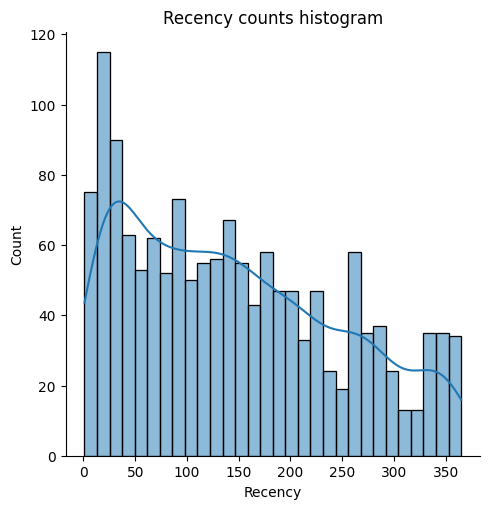

In [40]:
sns.displot(rfm_df['Recency'], kind='hist', bins=30, kde=True)
plt.title('Recency counts histogram')
plt.show()

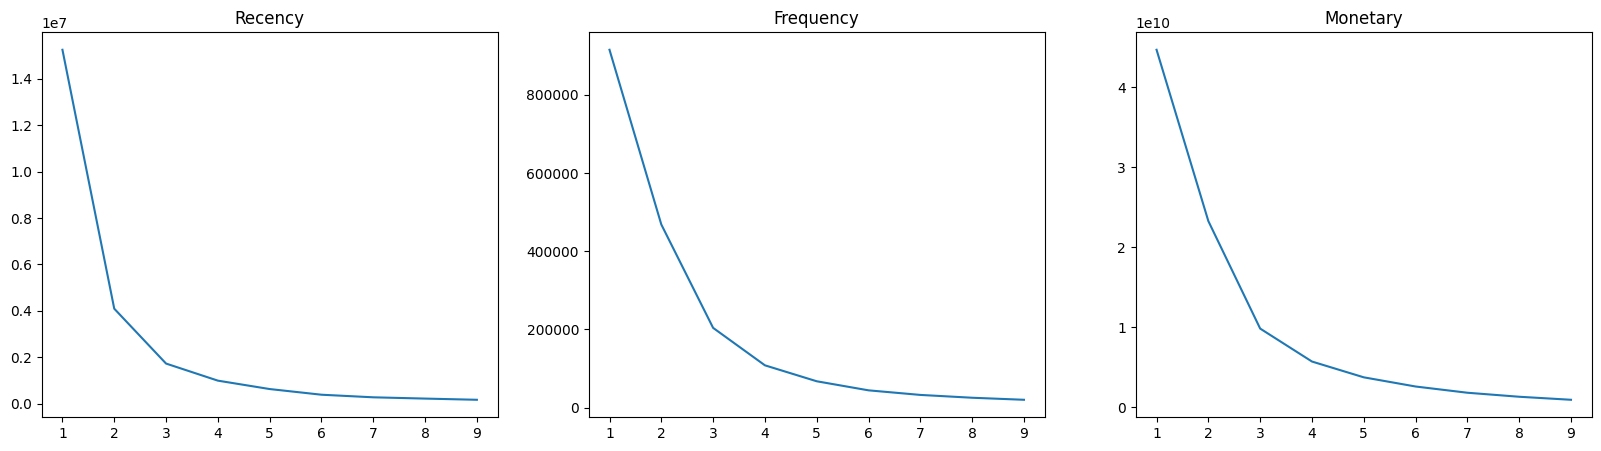

In [42]:
# Recency kmeans 계산을 위한 elbow point: 엘보우 포인트는 클러스터의 수가 증가함에 따라 클러스터 내 오차 제곱합(SSE: Sum of Squared Errors)이 어떻게 변하는지를 보여줌. 엘보우 포인트는 SSE의 감소율이 급격하게 줄어드는 지점으로, 이 지점에서는 클러스터의 수를 증가시켜도 성능이 크게 향상되지 않는다는 것을 의미
from sklearn.cluster import KMeans

recency_point = {}
frequency_point = {}
monetary_point = {}

rfm_df_recency = rfm_df[['Recency']].copy()
rfm_df_frequency = rfm_df[['Frequency']].copy()
rfm_df_monetary = rfm_df[['Monetary']].copy()

for k in range(1, 10):
  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_df_recency)
  rfm_df_recency['cluster'] = kmeans.labels_
  recency_point[k] = kmeans.inertia_

  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_df_frequency)
  rfm_df_frequency['cluster'] = kmeans.labels_
  frequency_point[k] = kmeans.inertia_

  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_df_monetary)
  rfm_df_monetary['cluster'] = kmeans.labels_
  monetary_point[k] = kmeans.inertia_

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ax0 = sns.lineplot(ax=axes[0], x=list(recency_point.keys()), y=list(recency_point.values()))
ax0.set_title('Recency')

ax1 = sns.lineplot(ax=axes[1], x=list(frequency_point.keys()), y=list(frequency_point.values()))
ax1.set_title('Frequency')

ax2 = sns.lineplot(ax=axes[2], x=list(monetary_point.keys()), y=list(monetary_point.values()))
ax2.set_title('Monetary')
plt.show()


In [43]:
# 5개 bins, 5점 기준으로 점수 부여
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["RecencyScore"] = pd.qcut(df_["Recency"], 5, labels=[5, 4, 3, 2, 1])   # 5가 가장 높은 점수
    df_["FrequencyScore"] = pd.qcut(
        df_["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]   # method = "first"는 순위 간 동륭을 처리할 때 사용
    )
    df_["MonetaryScore"] = pd.qcut(df_["Monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFMScore"] = df_["RecencyScore"].astype(str) + df_["FrequencyScore"].astype(str) + df_["MonetaryScore"].astype(str)   # RFMScore는 점수들의 str 조합

    return df_

rfm_score_df = get_rfm_scores(rfm_df)
rfm_score_df

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
0,USER_0000,108,1,99.98,3,1,1,311
1,USER_0001,60,31,15308.13,4,5,5,455
2,USER_0002,74,8,1573.49,4,2,3,423
3,USER_0003,18,11,1421.96,5,3,3,533
4,USER_0004,108,13,1524.42,3,3,3,333
...,...,...,...,...,...,...,...,...
1463,USER_1463,271,3,676.73,1,1,2,112
1464,USER_1464,88,19,2606.18,4,4,4,444
1465,USER_1465,195,2,127.90,2,1,1,211
1466,USER_1466,70,1,333.80,4,1,1,411


In [44]:
#transposition of the RFM table. This makes it easier to evaluate.
rfm_score_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,1468.0,145.292234,101.936959,1.00,56.00,132.00,221.0000,365.00
Frequency,1468.0,18.141008,24.976414,1.00,5.00,11.00,23.0000,328.00
Monetary,1468.0,3460.302548,5519.945748,6.99,714.75,1899.32,4273.3475,84405.83


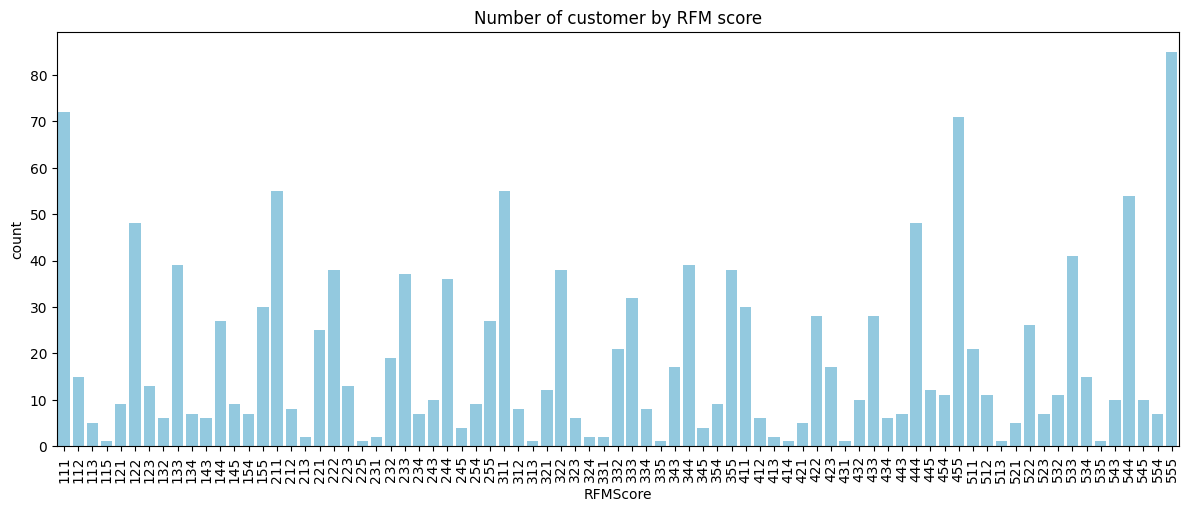

In [78]:
# 고점인 사람 찾기
plt.figure(figsize=(12, 5))
sns.countplot(rfm_score_df.sort_values('RFMScore'), x='RFMScore', color='skyblue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Number of customer by RFM score')
plt.show()

In [82]:
import re as r
# 10개로 구분
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm_score_df['Segment'] = rfm_score_df['RecencyScore'].astype(str) + rfm_score_df['FrequencyScore'].astype(str)
rfm_score_df['Segment'] = rfm_score_df['Segment'].replace(seg_map, regex=True)
rfm_score_df

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,Segment
0,USER_0000,108,1,99.98,3,1,1,311,About to Sleep
1,USER_0001,60,31,15308.13,4,5,5,455,Loyal Customers
2,USER_0002,74,8,1573.49,4,2,3,423,Potential Loyalists
3,USER_0003,18,11,1421.96,5,3,3,533,Potential Loyalists
4,USER_0004,108,13,1524.42,3,3,3,333,Need Attention
...,...,...,...,...,...,...,...,...,...
1463,USER_1463,271,3,676.73,1,1,2,112,Hibernating
1464,USER_1464,88,19,2606.18,4,4,4,444,Loyal Customers
1465,USER_1465,195,2,127.90,2,1,1,211,Hibernating
1466,USER_1466,70,1,333.80,4,1,1,411,Promising


In [83]:
rfm_score_df.groupby('Segment').mean()

,Recency,Frequency,Monetary
Segment,,,
About to Sleep,132.819672,3.893443,569.002377
At Risk,246.794258,15.167464,2775.359282
Can't Lose,252.616438,40.424658,7581.208356
Champions,22.246988,44.048193,9097.175482
Hibernating,255.521311,3.800000,669.652721
Loyal Customers,93.695312,34.882812,6585.800391
Need Attention,134.109375,11.015625,1799.441719
New Customers,19.484848,2.151515,434.219394
Potential Loyalists,46.208955,8.840796,1625.904030
